In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

#### Load the Dataset

In [2]:
# Load the dataset
file_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\Riley_O'Rorke_Capstone_Data.xlsx"
df = pd.read_excel(file_path, header=0)  # Ensure headers are recognized

#### Data Preprocessing

In [ ]:
import pandas as pd

# Drop unnecessary columns
columns_to_keep = ["C.[EntryTimestamp]", "C.[DataValue]"]
df = df[columns_to_keep]

# Convert measurement values to numeric
df['C.[DataValue]'] = pd.to_numeric(df['C.[DataValue]'], errors='coerce')

# Convert timestamps to datetime and set as index
df['C.[EntryTimestamp]'] = pd.to_datetime(df['C.[EntryTimestamp]'], errors='coerce')
df = df.dropna(subset=['C.[EntryTimestamp]']).sort_values(by='C.[EntryTimestamp]').reset_index(drop=True)
df.set_index('C.[EntryTimestamp]', inplace=True)

# Handle missing values (Interpolation preferred over dropping for ARIMA)
df['C.[DataValue]'] = df['C.[DataValue]'].interpolate(method='linear')

# Outlier Removal Using IQR
Q1 = df["C.[DataValue]"].quantile(0.25)
Q3 = df["C.[DataValue]"].quantile(0.75)
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["C.[DataValue]"] >= lower_bound) & (df["C.[DataValue]"] <= upper_bound)]


#### ACF / PACF Analysis

ADF Statistic: -4.827676316489294
p-value: 4.8129680863235095e-05
The series is stationary.


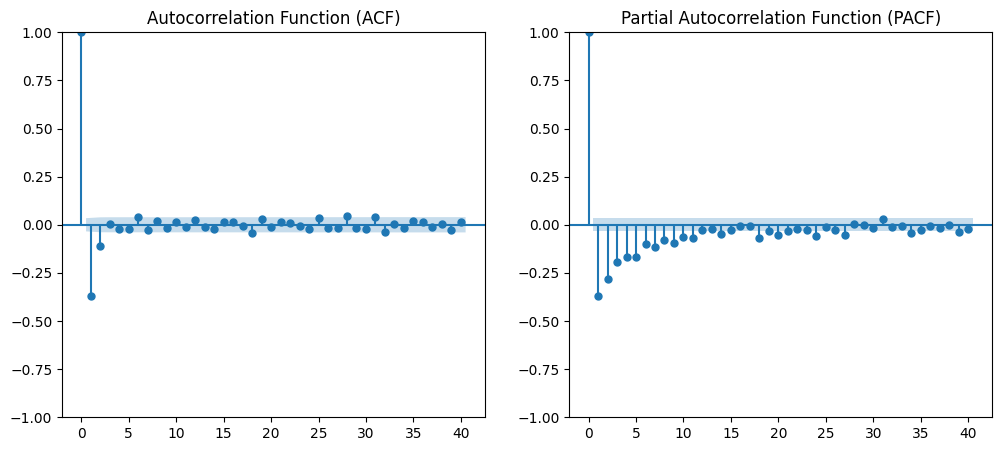

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller Test to check stationarity
adf_test = adfuller(df["C.[DataValue]"])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Differencing is needed.")

# Plot ACF and PACF to determine ARIMA (p, d, q) parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df["C.[DataValue]"].diff().dropna(), ax=axes[0], lags=40)
axes[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(df["C.[DataValue]"].diff().dropna(), ax=axes[1], lags=40)
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()


#### Train Model

In [ ]:
# Define target variable (C.[DataValue])
y = df["C.[DataValue]"]

# Define ARIMA order (p, d, q) - can be optimized
p, d, q = 1, 0, 1  # Should be tuned based on ACF/PACF analysis

# Fit ARIMA model
model = ARIMA(y, order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Generate predictions
forecast_steps = 10  # Predict next 10 cycles
y_pred = model_fit.forecast(steps=forecast_steps)

# Convert predictions into a DataFrame
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='D')[1:]
predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted_Bore_Size': y_pred})

C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

                               SARIMAX Results                                
Dep. Variable:          C.[DataValue]   No. Observations:                 3248
Model:                 ARIMA(1, 0, 1)   Log Likelihood                7986.111
Date:                Sun, 02 Mar 2025   AIC                         -15964.222
Time:                        07:28:13   BIC                         -15939.878
Sample:                             0   HQIC                        -15955.501
                               - 3248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.9582      0.002   4.83e+04      0.000      79.955      79.961
ar.L1          0.9392      0.009    106.125      0.000       0.922       0.957
ma.L1         -0.7219      0.014    -50.444      0.0

C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Date,Predicted_Bore_Size
3248,2025-02-22 11:02:44.283,79.989210
3249,2025-02-23 11:02:44.283,79.987326
3250,2025-02-24 11:02:44.283,79.985557
3251,2025-02-25 11:02:44.283,79.983896
3252,2025-02-26 11:02:44.283,79.982335
3253,2025-02-27 11:02:44.283,79.980870
3254,2025-02-28 11:02:44.283,79.979493
3255,2025-03-01 11:02:44.283,79.978200
3256,2025-03-02 11:02:44.283,79.976986
3257,2025-03-03 11:02:44.283,79.975845


#### Model Evaluation

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0154
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0207


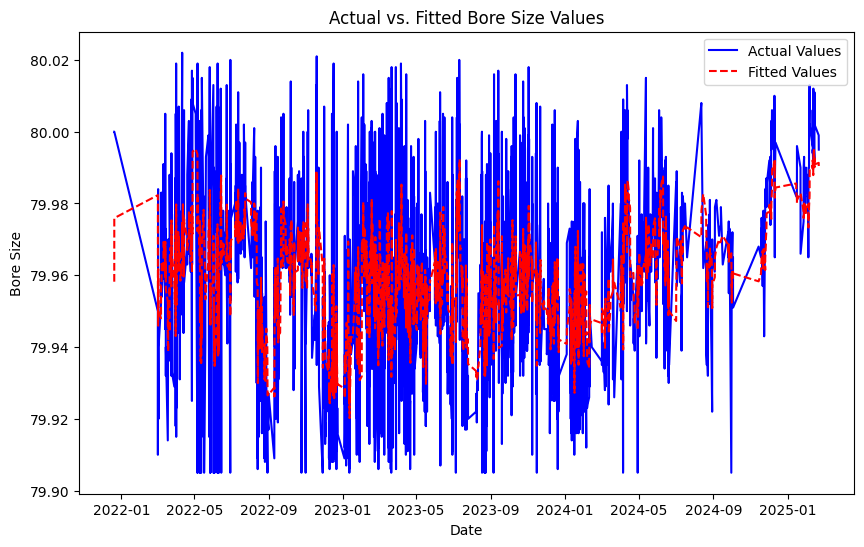

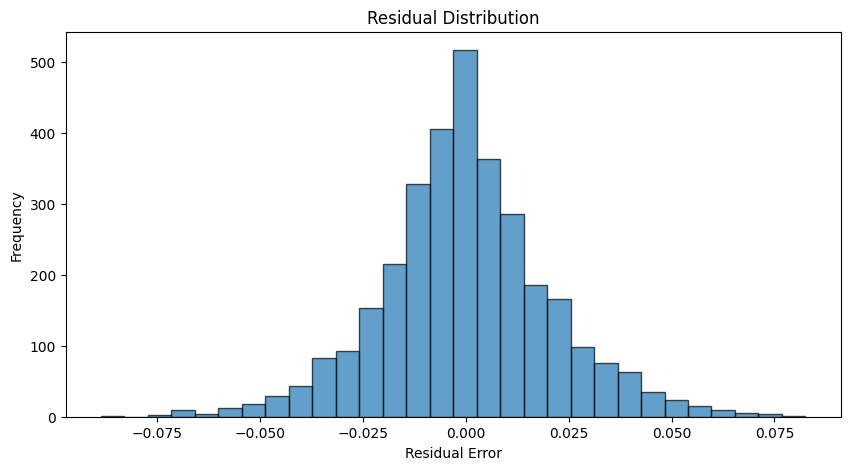

In [ ]:
# Generate predictions for the same time range
y_pred = model_fit.fittedvalues

# Calculate evaluation metrics
mae = mean_absolute_error(df["C.[DataValue]"], y_pred)
mse = mean_squared_error(df["C.[DataValue]"], y_pred)
rmse = np.sqrt(mse)

# Print the results
print(f"Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["C.[DataValue]"], label="Actual Values", color='blue')
plt.plot(df.index, y_pred, label="Fitted Values", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Bore Size")
plt.title("Actual vs. Fitted Bore Size Values")
plt.legend()
plt.show()

# Residual Analysis
residuals = df["C.[DataValue]"] - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()



#### Predict Future Wear

In [9]:
# Define how many future cycles to predict
future_cycles = 10  # Adjust as needed

# Generate future timestamps
future_dates = pd.date_range(start=df.index[-1], periods=future_cycles + 1, freq='D')[1:]

# Predict future bore sizes using the ARIMA model
future_predictions = model_fit.forecast(steps=future_cycles)

# Create a DataFrame for future predictions
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Bore_Size": future_predictions
})

# Compute bore size changes over time
future_df["Bore_Size_Change"] = future_df["Predicted_Bore_Size"].diff().fillna(0)

# Define wear classification function
def classify_wear(change):
    if change < 0.001:                    # Adjust as needed
        return "Normal Wear"
    elif 0.001 <= change < 0.005:         # Adjust as needed
        return "Moderate Wear"
    else:
        return "Critical Wear"

# Assign wear labels to future cycles
future_df["Predicted_Wear_Stage"] = future_df["Bore_Size_Change"].apply(classify_wear)

C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Finalized Dataset

In [10]:
# Ensure consistency in dataset structure
df["Predicted_Bore_Size"] = np.nan  # Set actual cycles to NaN in prediction column
df["Predicted_Wear_Stage"] = np.nan

# Align column names before concatenation
future_df = future_df.set_index("Date")
future_df = future_df.reset_index()

# Final dataset
df = df.reset_index()
final_df = pd.concat([df, future_df], ignore_index=True)

# Save predicted dataset
output_path = r"G:\College\University of Montana\Semester 4\Capstone\MSBA-Capstone-Riley-ORorke\data\arima_future_wear_predictions.xlsx"
final_df.to_excel(output_path, index=False, engine='openpyxl')

# Display final dataset
display(final_df)


,C.[EntryTimestamp],C.[DataValue],Predicted_Bore_Size,Predicted_Wear_Stage,Date,Bore_Size_Change
0,2021-12-20 09:39:04.333,80.00,NaN,NaN,NaT,NaN
1,2021-12-20 10:59:53.317,80.00,NaN,NaN,NaT,NaN
2,2022-03-02 04:14:55.567,79.95,NaN,NaN,NaT,NaN
3,2022-03-02 04:26:28.690,79.91,NaN,NaN,NaT,NaN
4,2022-03-02 04:26:28.690,79.91,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...
3253,NaT,NaN,79.980870,Normal Wear,2025-02-27 11:02:44.283,-0.001466
3254,NaT,NaN,79.979493,Normal Wear,2025-02-28 11:02:44.283,-0.001377
3255,NaT,NaN,79.978200,Normal Wear,2025-03-01 11:02:44.283,-0.001293
3256,NaT,NaN,79.976986,Normal Wear,2025-03-02 11:02:44.283,-0.001214
